# Loading MAST Data Remotely

This notebooks demonstrates how to remotely load data from the archive using `s3`.  

Firstly, let's import the dependancies and load the some configuration. This is just boilerplate for the rest of the notebook.

In [1]:
import requests
import s3fs
import getpass
import zarr
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import datatree
import yaml
from skimage.exposure import rescale_intensity
from skimage.filters import median

with open('config.yml') as file_handle:
    config = yaml.load(file_handle, yaml.FullLoader)


ENDPOINT_URL = config['s3_api']
GRAPHQL_ENDPOINT_URL = config['graphql_api']

Setup a `gql` client for querying the database

In [2]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url=GRAPHQL_ENDPOINT_URL)
# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

### Zarr & S3
The data in the archive is stored in [Zarr](https://zarr.readthedocs.io/en/stable/getting_started.html) files. Zarr files are very similar to the HDF format. They may store multiple multi-dimensional arrays and similar advanced features such as groups and meta data attributes. The advantages of Zarr over HDF is that the format is optimized for modern cloud storage systems such as `s3`.

[S3](https://aws.amazon.com/pm/serv-s3/?trk=777b3ec4-de01-41fb-aa63-cde3d034a89e&sc_channel=ps&ef_id=Cj0KCQjw06-oBhC6ARIsAGuzdw0F1kYMoyfJjn7PPUEjXp3yCxvohWjtqi1xKyscTg7n9ys01Fi72p8aAnxOEALw_wcB:G:s&s_kwcid=AL!4422!3!638364429349!e!!g!!aws%20s3%20block%20storage!19096959014!142655567223) is a cloud object storage technology for data which organises data into "buckets". The MAST data is stored in a s3 bucket called "mast" at our self-hosted endpoint:


In [3]:
print("S3 endpoint:", ENDPOINT_URL)

S3 endpoint: http://localhost:9000


We can connect to the remote file system using the `s3fs` library. This provides some basic file system functionality, such as listing the entries.

```{note}
Here we are accessing the data using an authenticated user. If the data (or sections of the data) were made public, then we would not need the authentication at this point.
```

In [4]:
# If the data were made public we could access it with the following line:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': ENDPOINT_URL})

# Connect to s3 with authentication
# password = getpass.getpass()
# s3 = s3fs.S3FileSystem(anon=False, key='sljack', secret=password, client_kwargs={'endpoint_url': ENDPOINT_URL})

All of the signals are stored in the zarr format under their name at this endpoint. For example, the AMC plasma current data can be found at `s3://mast/AMC_PLASMA_CURRENT.zarr`. Each zarr file contains a group for each shot within the dataset. We can open the contents of the file remotely. Here we're going to open the file and list the number of shots (groups) exist within the file.

In [5]:
store = zarr.storage.FSStore('s3://mast/AMC_PLASMA_CURRENT.zarr', fs=s3)
store = zarr.LRUStoreCache(store, max_size=2**28)
handle = zarr.open_consolidated(store)
groups = list(handle.groups())

print(f"There are {len(groups)} shots within this signal.")

There are 1580 shots within this signal.


### Data Analysis with Remote Data

We're going to perform a simple plotting task. We will:

 - Load the plasma current data as a `xarray.Dataset`
 - Slice every shot between 0 seconds and .2 seconds.
 

In [6]:
def load_group(group):
    """Helper function to load group data"""
    dataset = xr.Dataset(
        dict(data=xr.DataArray(group['data'], dims=['time']),
             error=xr.DataArray(group['error'], dims=['time']), 
            time=xr.DataArray(group['time'], dims=['time'])), attrs=group.attrs)
    return dataset

plasma_shots = []
for shot_id, group in groups[-10:]:
    dataset = load_group(group)
    dataset = dataset.sel(time=slice(0, .3))
    plasma_shots.append(dataset)

In the code above, we load each item as an `xarray` dataset, with the data, time, and error data all together.

In [7]:
plasma_shots[0]

<xarray.Dataset>
Dimensions:  (time: 1500)
Coordinates:
  * time     (time) float32 0.0001998 0.0003998 0.0005996 ... 0.2996 0.2998 0.3
Data variables:
    data     (time) float32 -7.669 -9.169 -5.618 ... -0.4501 -0.4894 -0.1201
    error    (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    description:    Plasma Current
    generic_name:   IP
    label:          Plasma Current
    mds_name:       \TOP.ANALYSED.AMC.PLASMA:CURRENT
    pass_:          0
    rank:           1
    ...             ...
    signal_name:    AMC_PLASMA CURRENT
    signal_status:  1
    source_alias:   amc
    time_index:     0
    type:           Analysed
    units:          kA

Finally, we can plot the 10 shots we loaded and cropped. 

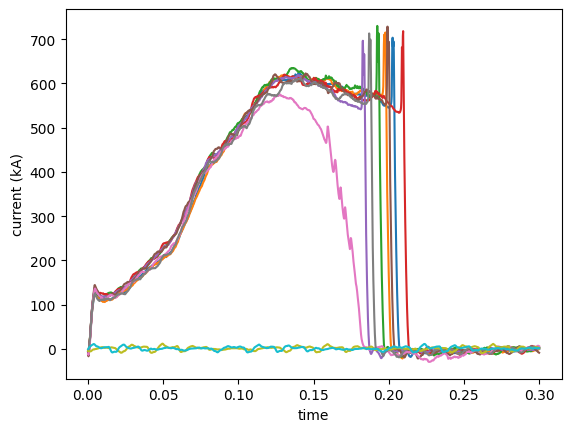

In [8]:
for current in plasma_shots:
    plt.plot(current.time, current.data)
    plt.xlabel('time')
    plt.ylabel(f"current ({current.attrs['units']})")

Let's try now try looking at the average current for all the shots in the database. Here we are going to:

 - Load all of the plasma current data each as a `xarray.Dataset`
 - Slice the current between `0` and `.2` seconds
 - Take the average of the plasma current
 - Filter any shots with an average current less than `200.0`
 

In [9]:
plasma_shots = []
values = []
for shot_id, group in reversed(groups):
    dataset = load_group(group)
    dataset = dataset['data'].sel(time=slice(0, .3))
    value = dataset.mean()
    if value > 200.0:
        plasma_shots.append((int(shot_id), value))

Let's collect the results and plot the average current as a function of shot number for the entire campaign

Text(0, 0.5, 'Current')

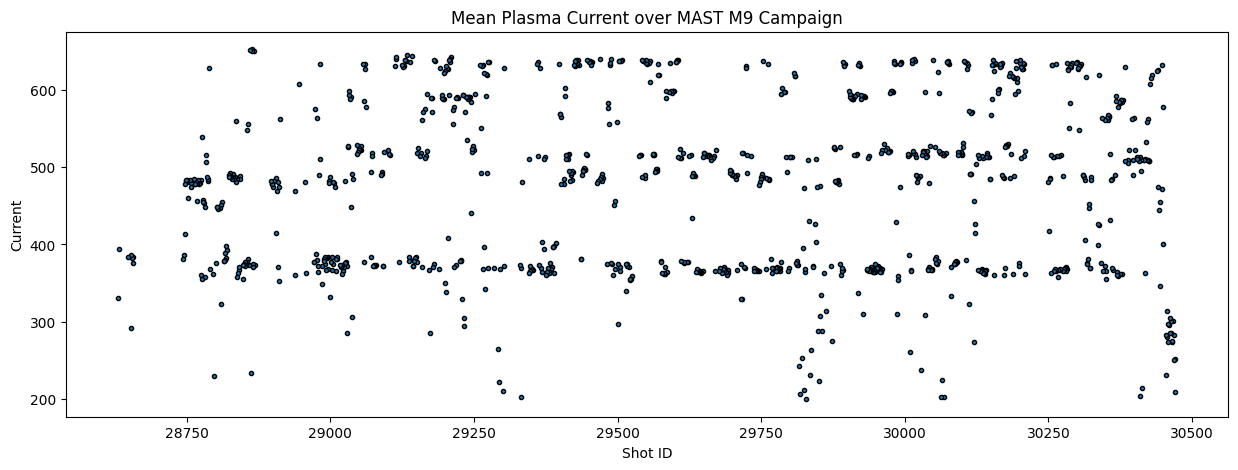

In [10]:
df = pd.DataFrame(plasma_shots, columns=['shot', 'mean_current'])

plt.figure(figsize=(15, 5))
plt.scatter(df.shot, df.mean_current, marker='.', edgecolor='black')
plt.title('Mean Plasma Current over MAST M9 Campaign')
plt.xlabel('Shot ID')
plt.ylabel('Current')

## Larger Data - Raw IR Data

Let's try something a little more complicated. Here we're going to find all RIR image data signals from the database with a height greater than `200` pixels and then load and process them.

First we will query the meta database for:

 - The url location of the data in the s3 bucket.
 - The shot ids which have `rir` image data.
 - The shape of each image, which is stored as a meta-data attribute in the database.

 We will use the graphql api to achieve this.


In [11]:
# Query the metadata with GraphQL
query = gql("""
  query ($dataset: String!) {
    all_signal_datasets (where: {name: {eq: $dataset}}){
      signal_datasets {
          url
          signals {
              shot_id
              shape
          }
      }
    }
  }
""")

result = client.execute(query, variable_values={'dataset': "RIR"})
print(result)

 # Pull out the URL of the Zarr store
rir_metadata = result['all_signal_datasets']['signal_datasets'][0]
rir_dataset_url = rir_metadata['url']

# Create a dataframe containing the metadata of the signals
df = pd.DataFrame(rir_metadata['signals'])
df = df.loc[df['shape'].map(lambda shape: shape[1] > 200)]

# Print the location of the dataset in s3
print(f"S3 Dataset url is {rir_dataset_url}")

# Show part of the dataframe of meta-data we loaded
df.head()

{'all_signal_datasets': {'signal_datasets': [{'url': 's3://mast/RIR.zarr', 'signals': [{'shot_id': 28416, 'shape': [59, 256, 320]}, {'shot_id': 28417, 'shape': [59, 256, 320]}, {'shot_id': 28418, 'shape': [58, 256, 320]}, {'shot_id': 28420, 'shape': [91, 256, 320]}, {'shot_id': 28421, 'shape': [124, 256, 320]}, {'shot_id': 28422, 'shape': [124, 256, 320]}, {'shot_id': 28423, 'shape': [123, 256, 320]}, {'shot_id': 28424, 'shape': [221, 256, 320]}, {'shot_id': 28425, 'shape': [95, 256, 320]}, {'shot_id': 28426, 'shape': [95, 256, 320]}, {'shot_id': 28427, 'shape': [95, 256, 320]}, {'shot_id': 28428, 'shape': [95, 256, 320]}, {'shot_id': 28429, 'shape': [95, 256, 320]}, {'shot_id': 28584, 'shape': [95, 256, 320]}, {'shot_id': 28589, 'shape': [95, 256, 320]}, {'shot_id': 28590, 'shape': [95, 256, 320]}, {'shot_id': 28591, 'shape': [95, 256, 320]}, {'shot_id': 28592, 'shape': [95, 256, 320]}, {'shot_id': 28597, 'shape': [95, 256, 320]}, {'shot_id': 28598, 'shape': [95, 256, 320]}, {'shot_id

shot_id            shape
0    28416   [59, 256, 320]
1    28417   [59, 256, 320]
2    28418   [58, 256, 320]
3    28420   [91, 256, 320]
4    28421  [124, 256, 320]

Now we have the location of the data (`rir_dataset_url`) and we know the shot IDs we want, we can just load those items from the data archive 

In [12]:
store = zarr.storage.FSStore(rir_dataset_url.lower(), fs=s3)
store = zarr.LRUStoreCache(store, max_size=2**30)
handle = zarr.open_consolidated(store)
# Use the meta-data to filter which groups we want to load
groups = [handle[shot_id] for shot_id in df.shot_id]

print(f"Number of groups to load {len(groups)}")

Number of groups to load 219


We can now open the datasets we found over s3. This time, we are going to use the [datatree library](https://xarray-datatree.readthedocs.io/en/latest/) to read the shots. Datatree is like a hierachical version of `xarray`, which allows us to perform slicing and mapping selections over groups of datasets.

In [13]:
data = {str(shot_id): xr.open_zarr(store, group=group.name) for shot_id, group in zip(df.shot_id, groups)}
dataset = datatree.DataTree.from_dict(data)
dataset

DataTree('None', parent=None)
├── DataTree('28416')
│       Dimensions:  (time: 59, height: 256, width: 320)
│       Coordinates:
│         * time     (time) float64 -0.04754 -0.04437 -0.0412 ... 0.1299 0.133 0.1362
│       Dimensions without coordinates: height, width
│       Data variables:
│           data     (time, height, width) uint16 dask.array<chunksize=(15, 128, 160), meta=np.ndarray>
│       Attributes:
│           CLASS:           IMAGE
│           IMAGE_SUBCLASS:  IMAGE_INDEXED
│           IMAGE_VERSION:   1.2
│           description:     Medium wavelength infrared camera
│           filename:        rir028416.ipx
│           format:          IPX
│           pass_:           -1
│           run_id:          -1
│           shot:            28416
│           source_alias:    rir
│           status:          1
│           type:            Image
├── DataTree('28417')
│       Dimensions:  (time: 59, height: 256, width: 320)
│       Coordinates:
│         * time     (time) float64 -0.04754 -0.04437 -0.0412 ... 0.1299 0.133 0.1362
│       Dimensions without coordinates: height, width
│       Data variables:
│           data     (time, height, width) uint16 dask.array<chunksize=(15, 128, 160), meta=np.ndarray>
│       Attributes:
│           CLASS:           IMAGE
│           IMAGE_SUBCLASS:  IMAGE_INDEXED
│           IMAGE_VERSION:   1.2
│           description:     Medium wavelength infrared camera
│           filename:        rir028417.ipx
│           format:          IPX
│           pass_:           -1
│           run_id:          -1
│           shot:            28417
│           source_alias:    rir
│           status:          1
│           type:            Image
├── DataTree('28418')
│       Dimensions:  (time: 58, height: 256, width: 320)
│       Coordinates:
│         * time     (time) float64 -0.04754 -0.04437 -0.0412 ... 0.1267 0.1299 0.133
│       Dimensions without coordinates: height, width
│       Data variables:
│           data     (time, height, width) uint16 dask.array<chunksize=(15, 128, 160), meta=np.ndarray>
│       Attributes:
│           CLASS:           IMAGE
│           IMAGE_SUBCLASS:  IMAGE_INDEXED
│           IMAGE_VERSION:   1.2
│           description:     Medium wavelength infrared camera
│           filename:        rir028418.ipx
│           format:          IPX
│           pass_:           -1
│           run_id:          -1
│           shot:            28418
│           source_alias:    rir
│           status:          1
│           type:            Image
├── DataTree('28420')
│       Dimensions:  (time: 91, height: 256, width: 320)
│       Coordinates:
│         * time     (time) float64 -0.04754 -0.04437 -0.0412 ... 0.2312 0.2344 0.2376
│       Dimensions without coordinates: height, width
│       Data variables:
│           data     (time, height, width) uint16 dask.array<chunksize=(23, 64, 160), meta=np.ndarray>
│       Attributes:
│           CLASS:           IMAGE
│           IMAGE_SUBCLASS:  IMAGE_INDEXED
│           IMAGE_VERSION:   1.2
│           description:     Medium wavelength infrared camera
│           filename:        rir028420.ipx
│           format:          IPX
│           pass_:           -1
│           run_id:          -1
│           shot:            28420
│           source_alias:    rir
│           status:          1
│           type:            Image
├── DataTree('28421')
│       Dimensions:  (time: 124, height: 256, width: 320)
│       Coordinates:
│         * time     (time) float64 -0.04754 -0.04437 -0.0412 ... 0.3358 0.339 0.3421
│       Dimensions without coordinates: height, width
│       Data variables:
│           data     (time, height, width) uint16 dask.array<chunksize=(31, 64, 160), meta=np.ndarray>
│       Attributes:
│           CLASS:           IMAGE
│           IMAGE_SUBCLASS:  IMAGE_INDEXED
│           IMAGE_VERSION:   1.2
│           description:     Medium wavelength infrared camera
│           filename:        rir028421.ipx
│           format:  

Now we'll process the images a little futher. We will:

 - Select one frame from email.mime import image
from the camera
 - Crop the edges of the image
 - Normalize the image 

 ```{note}
With `xarray` and `datatree` we do not load all of the data from the camera, we are only loading the 10th frame and the cropped pixels. `xarray` will use `dask` under the hood to lazily load the data.
```

In [14]:
def process_image(img):
    """Pre-process the image data"""
    img = median(img)             # median filter 
    img = rescale_intensity(img)  # rescale to 0-1 range
    return img

dataset = dataset.isel(time=10, width=slice(10, -10))
dataset = dataset.map(process_image)

Finally, we can plot some of the resulting images

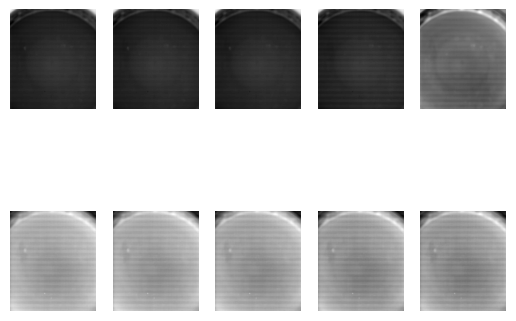

In [15]:
fig, axes = plt.subplots(2, 5)
for ax, item in zip(axes.flatten(), dataset.children.values()):
    ax.imshow(item['data'].T, cmap='gray')
    ax.axis('off')